# Building and Training a Neural Network!
We have learned a bunch of modularized layers. It's time to put them all together, and train a NeuralNet to recognize the digits in MNIST. In this notebook we will walk you through training a simple three-layer NeuralNetwork and then set you free to build the best net that you can to perform well on MNIST dataset.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import the layers
from nnetwork import *
# As usual, a bit of setup
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Digit Recognition

We are going to build a three-layer neural network and use it for recognizing the digits. For this purpose we will be using the famous MNIST dataset.

 Note that the neural network parameters will be stored in a dictionary (`model` below), where the keys are the parameter names and the values are numpy arrays. Below, we initialize toy data and a toy model that we will use to verify your implementations.

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


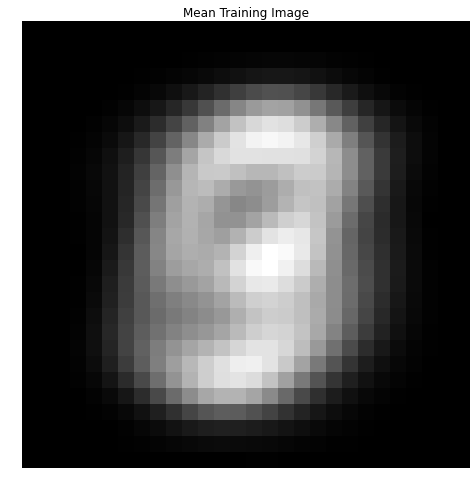

In [3]:
import mnist_loader as mnl
# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = mnl.get_mnist_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

# display the mean training image...
mean_train=np.mean(X_train,axis=0)
plt.imshow(mean_train.reshape(28,-1),cmap='gray')
plt.axis('off')
plt.title('Mean Training Image')

#
# Centralized the train, test, and validation data...
X_train=X_train-mean_train;
X_val=X_val-mean_train;
X_test=X_test-mean_train;


# Sanity check loss
Now we have all the ingredients in place. Now we are going to build a complete network. After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [4]:
#%pdb
#Initialize the weights
model = init_three_layer_neuralnet(weight_scale=0.01,input_feat_dim=32*32*3)

X = np.random.randn(1000, 3* 32* 32)
y = np.random.randint(10, size=1000)

# Compute the loss
loss, _ = three_layer_neuralnetwork(X, model, y, reg=0,verbose=1)

# Sanity check: Loss should be about log(10) = 2.3026, for a perfect random initalization of weights
print ('Sanity check loss (no regularization): ', loss)

# Sanity check: Loss should go up when you add regularization
loss, _ = three_layer_neuralnetwork(X, model, y, reg=1)
print ('Sanity check loss (with regularization): ', loss)

Sanity check loss (no regularization):  2.30258507921
Sanity check loss (with regularization):  2.31499904278


# Gradient check
After the loss looks reasonable, you should always use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [5]:
from gradient_check import *

num_inputs = 3
feat_dim = 5
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, feat_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = init_three_layer_neuralnet(input_feat_dim=feat_dim)
import copy

mcopy=copy.deepcopy(model)

loss, grads = three_layer_neuralnetwork(X, model, y,verbose=1)

for param_name in sorted(grads):
    f = lambda _: three_layer_neuralnetwork(X, model, y)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    #print e
    print ('%s max relative error: %e' % (param_name, e))
    

W1 max relative error: 6.259352e-07
W2 max relative error: 6.777853e-06
W3 max relative error: 7.187877e-07
b1 max relative error: 2.609175e-08
b2 max relative error: 2.530670e-08
b3 max relative error: 3.265247e-09


['Layer 1 Variance = 1.5610788745', 'Layer 2 Variance = 1.57736586195', 'Layer 3 Variance = 0.797416980616']
W1 max relative error: 3.684574e-07
W2 max relative error: 5.421051e-07
W3 max relative error: 5.656786e-06
b1 max relative error: 1.630637e-08
b2 max relative error: 6.167163e-09
b3 max relative error: 1.461265e-08


# Implementing Gradient Descent and Its Variants
To train the network we will use SGD with Momentum. Last assignment you implemented vanilla SGD. You will now implement the momentum update and the RMSProp update. Open the file `classifier_trainer.py` and familiarze yourself with the `ClassifierTrainer` class. It performs optimization given an arbitrary cost function data, and model. By default it uses vanilla SGD, which we have already implemented for you. First, run the optimization below using Vanilla SGD:

In [6]:
input_size = 4
num_classes = 3
num_inputs = 5

def init_toy_data():
  X = np.linspace(-0.2, 0.5, num=num_inputs*input_size).reshape(num_inputs, input_size)
  y = np.array([0, 1, 2, 2, 1])
  return X, y

from classifier_trainer import ClassifierTrainer


X,y=init_toy_data()

model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)

trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, three_layer_neuralnetwork,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.0, learning_rate_decay=1,
                                             update='sgd', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
print ('Final loss with vanilla SGD: %f' % (loss_history[-1], ))

starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
Final loss with vanilla SGD: 0.645848


In [37]:
model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)
trainer = ClassifierTrainer()
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, three_layer_neuralnetwork,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='momentum', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.046405
print ('Final loss with Momentum SGD: %f. We get: %f' % (loss_history[-1], correct_loss))

starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
Final loss with Momentum SGD: 0.165064. We get: 0.046405


In [36]:
model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)
trainer = ClassifierTrainer()
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, three_layer_neuralnetwork,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='nestrov-momentum', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.046405
print ('Final loss with Nestrov-Momentum SGD: %f. We get: %f' % (loss_history[-1], correct_loss))

starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
Final loss with Nestrov-Momentum SGD: 0.167607. We get: 0.046405


In [33]:
model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)
trainer = ClassifierTrainer()
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, three_layer_neuralnetwork,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='rmsprop', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.046405
print ('Final loss with RMSProp: %f. We get: %f' % (loss_history[-1], correct_loss))

starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
Final loss with RMSProp: 0.591524. We get: 0.046405


In [38]:
''''model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, three_layer_neuralnetwork,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='SMORMS3', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.046405
print ('Final loss with SMORMS3: %f. We get: %f' % (loss_history[-1], correct_loss))'''''

"'model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)\ntrainer = ClassifierTrainer()\n# call the trainer to optimize the loss\n# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)\nbest_model, loss_history, _, _ = trainer.train(X, y, X, y,\n                                             model, three_layer_neuralnetwork,\n                                             reg=0.001,\n                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,\n                                             update='SMORMS3', sample_batches=False,\n                                             num_epochs=100,\n                                             verbose=False)\ncorrect_loss = 0.046405\nprint ('Final loss with SMORMS3: %f. We get: %f' % (loss_history[-1], correct_loss))"

In [11]:
#Finding data distribution...
print ("Train distribution",np.bincount(y_train))
print ("Validation distribution",np.bincount(y_val))
print ("Test distribution",np.bincount(y_test))

Train distribution [4932 5678 4968 5101 4859 4506 4951 5175 4842 4988]
Validation distribution [ 991 1064  990 1030  983  915  967 1090 1009  961]
Test distribution [ 980 1135 1032 1010  982  892  958 1028  974 1009]


In [12]:
from classifier_trainer import *
trainer = ClassifierTrainer()
model=init_three_layer_neuralnet(weight_scale=1,input_feat_dim=X_train.shape[1],num_neurons=(10,10))
three_layer_neuralnetwork(X_train[:10000], model,y_train[:10000],0.001,verbose=1)
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(X_train[:10000], y_train[:10000], X_val, y_val,
                                             model, three_layer_neuralnetwork,
                                             num_epochs=5, reg=0.001,batch_size=64,
                                             momentum=0.9, learning_rate_decay = 0.95,
                                             learning_rate=0.01,update='momentum', verbose=True)

starting iteration  0
Finished epoch 0 / 5: cost 2.337285, train: 0.123000, val 0.122000, lr 1.000000e-02
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
starting iteration  210
starting iteration  220
starting iteration  230
starting iteration  240
starting iteration  250
starting iteration  260
starting iteration  270
starting iteration  280
starting iteration  290
starting iteration  300
starting iteration  310
starting iteration  320
starting iteration  330
starting iteration  340
starting iteration  350
starting iteration  360
starting iteration  370
starting iterat

In [13]:
from vis_utils import visualize_grid
def show_net_weights_mnist(model,weights='W1'):
    plt.imshow(visualize_grid(model[weights].T.reshape(-1, 28, 28), padding=3,isgrayscale=True).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

### Plot the training loss evolution history

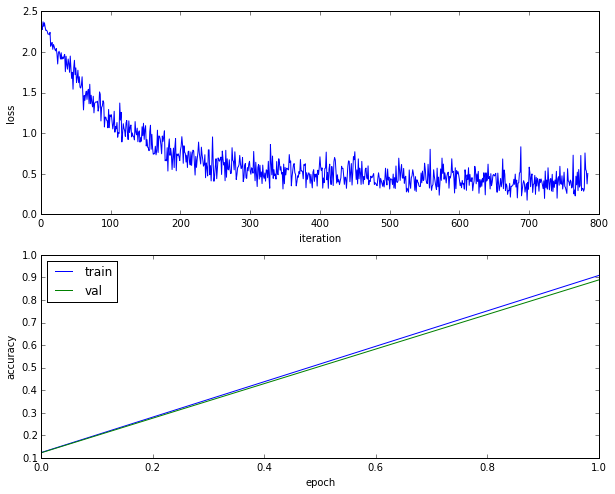

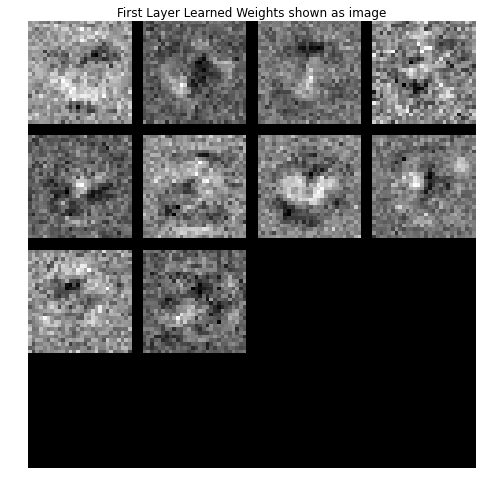

In [14]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
#print train_acc_history
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#Show the learned weights...
plt.title('First Layer Learned Weights shown as image')# they must look meaningful
show_net_weights_mnist(model)

In [15]:
#Initalizaing the Network
'''model=init_three_layer_neuralnet(weight_scale=1,input_feat_dim=X_train.shape[1],num_neurons=(20,20),num_classes=10);
#testing variance across the network they must be reasonable values, if the weights are initalized properly...
three_layer_neuralnetwork(X_train, model,y_train,0.001,verbose=1); '''

'model=init_three_layer_neuralnet(weight_scale=1,input_feat_dim=X_train.shape[1],num_neurons=(20,20),num_classes=10);\n#testing variance across the network they must be reasonable values, if the weights are initalized properly...\nthree_layer_neuralnetwork(X_train, model,y_train,0.001,verbose=1); '

In [16]:
#Training the Network
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(X_train, y_train, X_val, y_val,
                                             model, three_layer_neuralnetwork,
                                             num_epochs=5, reg=0.01,batch_size=128,
                                             momentum=0.9, learning_rate_decay = 0.95,
                                             learning_rate=1e-2,update='momentum', verbose=True)

starting iteration  0
Finished epoch 0 / 5: cost 1.493914, train: 0.893000, val 0.896400, lr 1.000000e-02
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
starting iteration  210
starting iteration  220
starting iteration  230
starting iteration  240
starting iteration  250
starting iteration  260
starting iteration  270
starting iteration  280
starting iteration  290
starting iteration  300
starting iteration  310
starting iteration  320
starting iteration  330
starting iteration  340
starting iteration  350
starting iteration  360
starting iteration  370
starting iterat

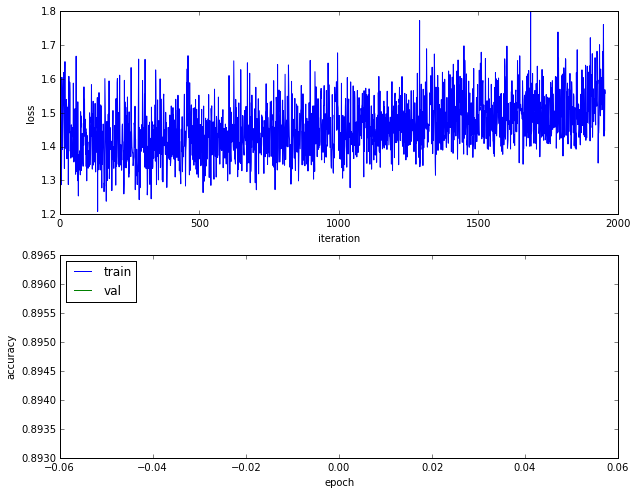

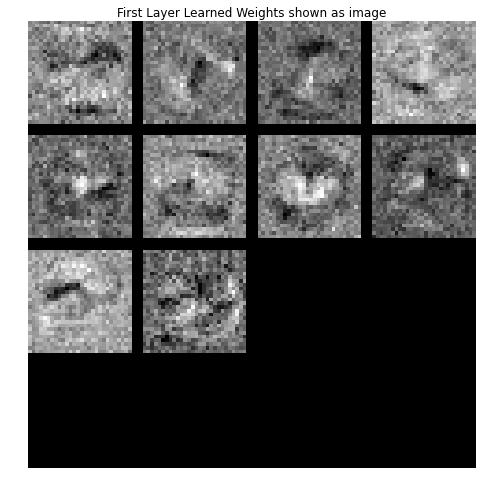

In [17]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
#print train_acc_history
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#Show the learned weights...
plt.title('First Layer Learned Weights shown as image')# they must look meaningful
show_net_weights_mnist(model)

In [18]:
scores_test = three_layer_neuralnetwork(X_test, model)
y_pred_test = np.argmax(scores_test, axis=1)
test_acc = np.mean(y_test == y_pred_test)
print ('Test Accuracy= {}'.format(test_acc))

Test Accuracy= 0.9246


Predicted     0     1     2     3     4    5    6     7    8     9    All
Actual                                                                   
0           965     0     0     0     0    5    2     5    1     2    980
1             0  1113     0     4     0    4    2     2   10     0   1135
2            13     4   924    19    10    3    9    10   38     2   1032
3             0     4    18   928     2   30    1     9   10     8   1010
4             2     1     7     0   925    1    7     3    5    31    982
5             9     4     7    33     6  792    9     6   22     4    892
6            14     3     9     0     8   13  905     1    5     0    958
7             3     5    27     8     5    0    0   945    4    31   1028
8            10    14    13    18    14   43    6    10  831    15    974
9             9     4     1    11    35   10    1    12    8   918   1009
All        1025  1152  1006  1021  1005  901  942  1003  934  1011  10000


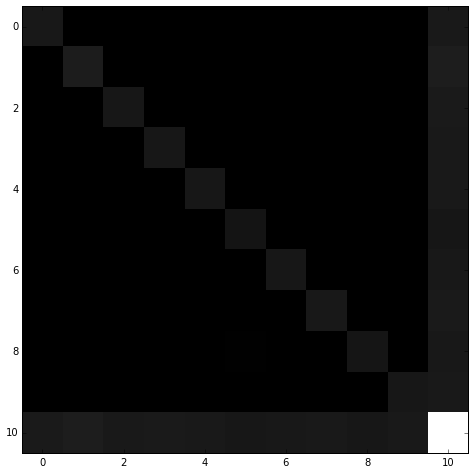

In [19]:
#Confusion Matrix Across classes...
from tools import print_confusion_matrix
df=print_confusion_matrix(y_pred_test,y_test)
print (df)
plt.imshow(df.as_matrix())

In [20]:
np.save('model-10-epochs-94',model)